# <center>Air Passenger Forecasting</center>

### Aim :
- To predict / forecast the number of passengers travelling using aeroplanes based on time series data.  Objective is- Build a model to forecast the demand(passenger traffic) in Airplanes.
- It is a typical **Time Series Analysis** problem.

### <center>Dataset Attributes</center>
    
- **Month** : Month and Year values
- **#Passengers** : Number of passengers travelling using aeroplanes.

### Notebook Contents :
- Dataset Information
- Time Series Analysis
- Modeling
- Conclusion

### What will we learn :
- Statistical Tests for Time Series Analysis.
- Order selection for ARIMA & SARIMA models.
- In-sample and Out-of-sample forecasting using rolling & non-rolling methods.
- Difference between forecast function and predict function of ARIMA & SARIMA.


# <center>Dataset Information</center>

### Import the Necessary Libraries : 

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format

from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA 
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv("S:\My Projects\TS\AirPassengers.csv")
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


### Data Info :

In [6]:
data.shape

(144, 2)

In [8]:
data.columns

Index(['Month', '#Passengers'], dtype='object')

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [14]:
# sns.heatmap(data.isnull(),cmap = 'magma',cbar = False);

In [18]:
data.isna().sum()

Month          0
#Passengers    0
dtype: int64

- **No null values** present in the data!

In [21]:
data.describe()

,#Passengers
count,144.00
mean,280.30
std,119.97
min,104.00
25%,180.00
50%,265.50
75%,360.50
max,622.00


In [23]:
data['Date'] = pd.to_datetime(data['Month'])
data = data.drop(columns = 'Month')
data = data.set_index('Date')
data = data.rename(columns = {'#Passengers':'Passengers'})
data.head()

,Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


- Converting the datatype of the **Month** column to datetime datatype and setting it as the index of the dataset.
- Renaming the column **Month** to **Date** and **#Passengers** to **Passengers** as well.
- It is a monthly distributed data.

# <center>**Time Series Analysis**</center>

#### Supportive Functions for Time Series Analysis :

In [28]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [30]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

### Components of Time Series :
- A Time Series consists of the following components :

    - **Trend** : Long term direction of the data.
    
    E.g : Year on year rising temperature of the Earth due to Global Warming.
    
    - **Seasonality** : Short term repetitve patterns of the data due to the weather seasons.
    
    E.g : Sale of sweaters specifically in the winter season.
    
    - **Cyclic Variations** : Short term repetitive patterns of the data over a period of 1 year.
    
    E.g : It usually consists of the Business Quarters i.e Q1, Q2, Q3 & Q4.
    
    - **Irregularities** : Random and unforseen fluctuations in the data.
    
    E.g : Occurrences of Earthquakes or Floods, etc.
    
    
- **In order to assess a Time Series, we need to consider the above components and make sure that our data is free from all these components in order to make a forecast.** 

Let's visualize the **Passengers** data for the above components!
- For this purpose, we use a function **seasonal_decompose** from the **statsmodel** library.
- This function has a parameter, **model**, that needs to be assigned the value **additive** or **multiplicative**.
    - **Additive Model** : Data has same width and height of the seasonal patterns or peaks. Trend of the data is linear.
    - **Multiplicative Model** : Data has increasing / decreasing width and height of the seasonal patterns or peaks. Trend of the data is non-linear.

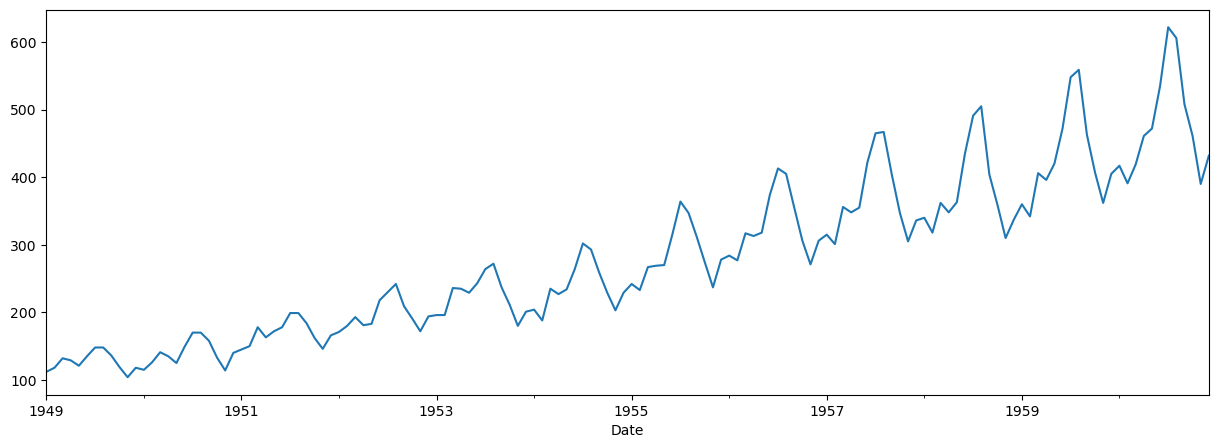

In [33]:
plt.figure(figsize = (15,5))
data['Passengers'].plot();

- From the above graph of **Passengers** data, we can say that it represents a **Multiplicative Model** as the data has increasing width & height of the peaks.
- Let us decompose the multiple components of the **Passengers** time series.

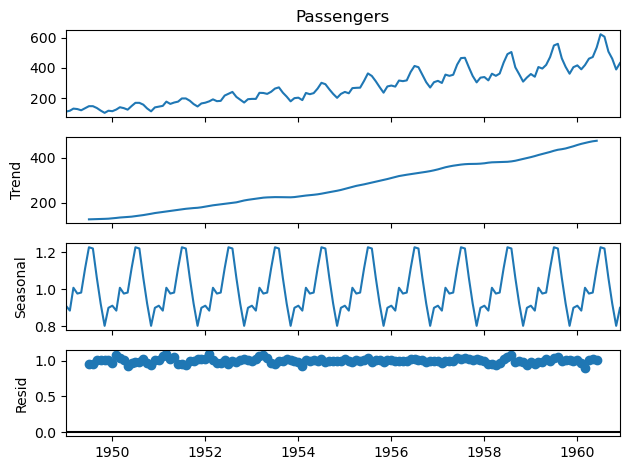

In [35]:
dec = sm.tsa.seasonal_decompose(data['Passengers'],period = 12, model = 'multiplicative').plot()
plt.show()

- Data clearly has a **linear uptrend**.
- A clear cut **seasonal** pattern of a 1 year duration is present in the data.
- We also need to check the statistical parameters w.r.t time.

### Stationarity :

- **Stationarity** is a concept for time series where statistical parameters like mean, variance, etc are all constant over time.
- For a time series, features are dependent on time i.e **features are a function of time**. Statistical paramters will change values over time as they are extracted from the features.
- If the time series is not stationary, then the predictions deviate from the original values and increase the error as we don't know the changes in these statistical parameters as they are a function of time.
- Thus, by making time series stationary, we kind of nullify the effects of statistical parameters on the forecast.
- To test stationarity, we will use **Augmented Dickey Fuller Test** : 
    - **Null Hypothesis** : It assumes that the time series is non-stationary.
    - **Alternate Hypothesis** : If the null hypothesis is rejected, then the time series is stationary.
    - Output of the **Augmented Dickey Fuller Test** include :
        - **Test Statistic**
        - **p-value**
        - **#Lags Used**
        - **Number of Observations Used**
        - **Critical Value (1%)**
        - **Critical Value (5%)**
        - **Critical Value (10%)**
- For the **Null Hypothesis** to be rejected and accepting that the time series is stationary, there are 2 requirements :
    - **Critical Value (5%)** > **Test Statistic**
    - **p-value** < 0.05

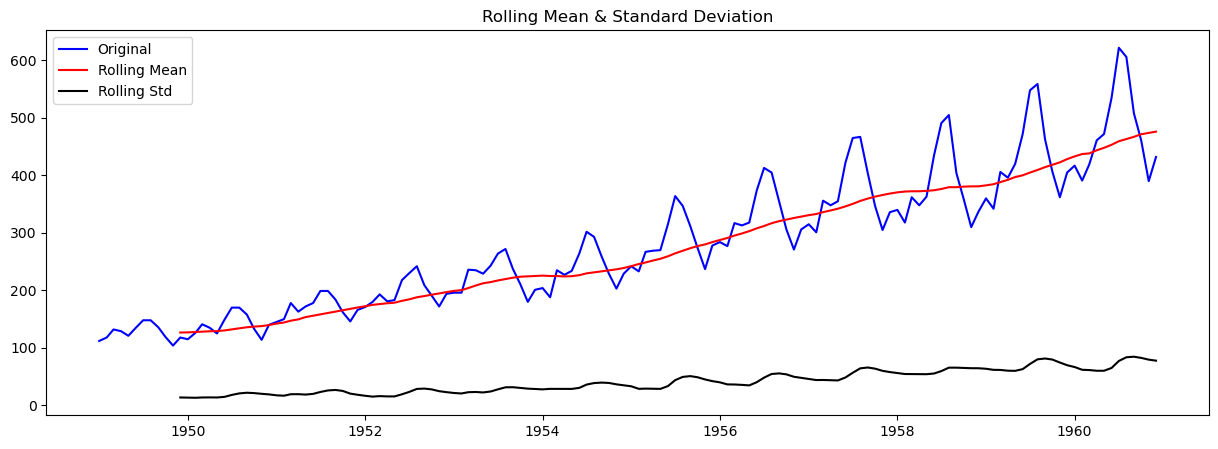

Results of Dickey-Fuller Test:
Test Statistic                  0.82
p-value                         0.99
#Lags Used                     13.00
Number of Observations Used   130.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [37]:
test_stationarity(data['Passengers'])

- For the **Passengers** time series data, 
    - **Rolling Mean** is clearly variable with time. 
    - **Rolling Standard Deviation** is has some crests - troughs that vary according to the time.
    - **Test Statistic : (0.82)** > **Critical Value (5%) : (-2.88)**
    - **p-value (0.99)** > 0.05
- Hence, **Null Hypothesis** cannot be rejected and we can conclude that the above **Passengers** time series is **not stationary**.
- In order to eliminate trend, seasonality and make the time series stationary, we will use **differencing** i.e subtracting the previous value from it's next value. We will work on log values of the data from here!

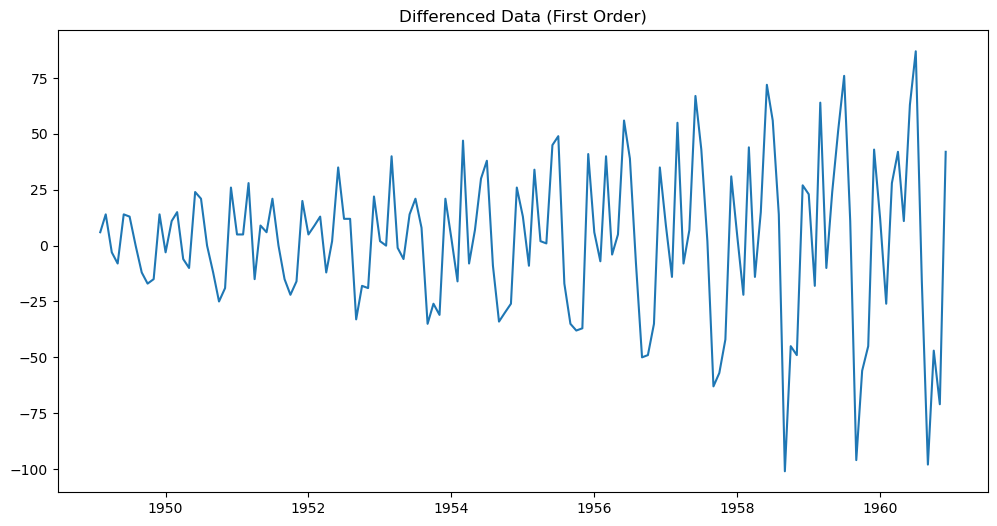

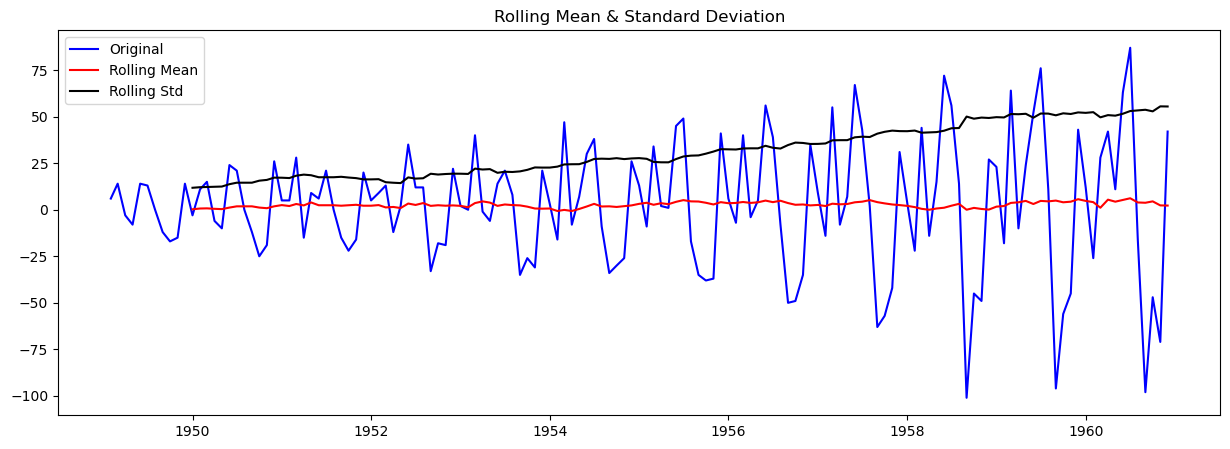

Results of Dickey-Fuller Test:
Test Statistic                 -2.83
p-value                         0.05
#Lags Used                     12.00
Number of Observations Used   130.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [39]:
# Differencing the data to remove trend
data_diff = data['Passengers'].diff().dropna()

# Plot the differenced data to see if the trend is removed
plt.figure(figsize=(12, 6))
plt.plot(data_diff)
plt.title('Differenced Data (First Order)')
plt.show()

# Test stationarity of the differenced data
test_stationarity(data_diff)

- We have taken the **log** of the data to deal with **stationarity** and **differencing** is done to handle **trend** and **seasonality**.
- **Trend** of the data has near about died down & their values have been reduced as well. However, **Seasonality** of the data is clearly visible.
- We now check the **stationarity** of the time series.

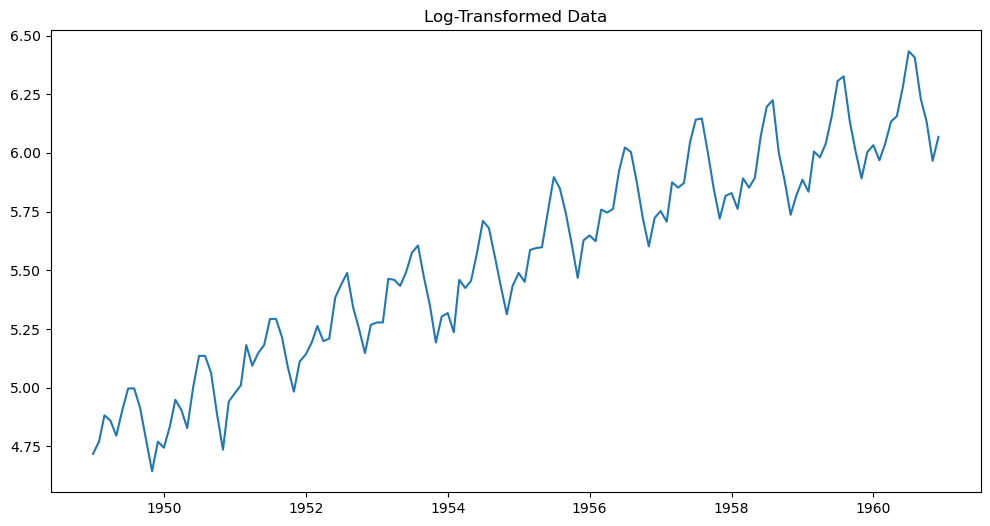

In [41]:
# Apply log transformation to stabilize variance
data_log = np.log(data['Passengers'])

# Plot the log-transformed data
plt.figure(figsize=(12, 6))
plt.plot(data_log)
plt.title('Log-Transformed Data')
plt.show()

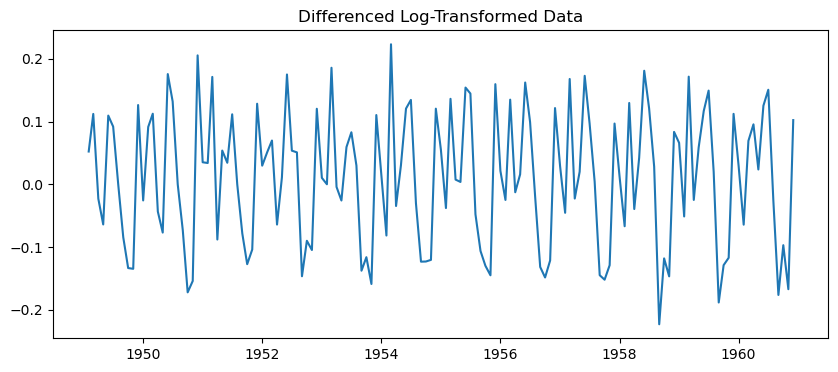

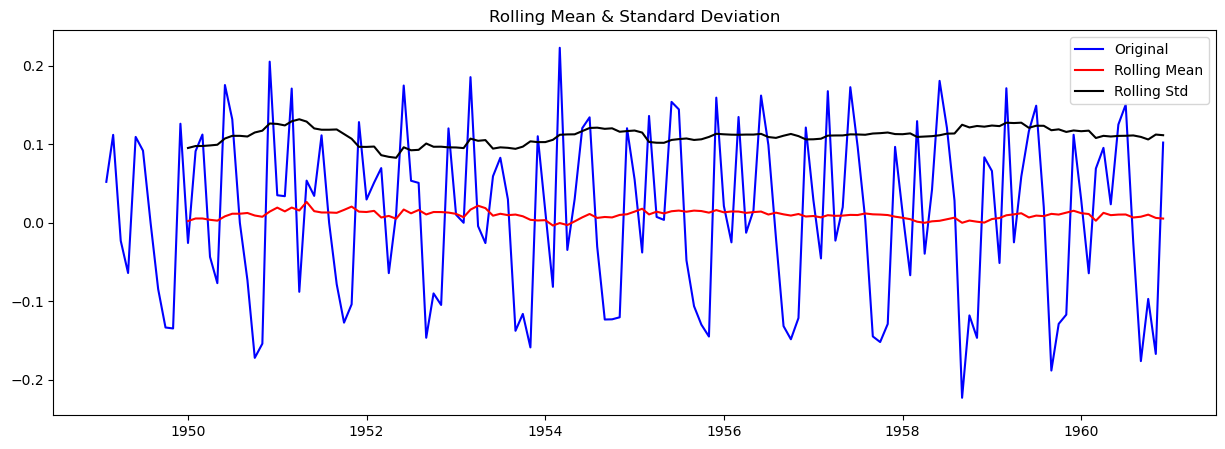

Results of Dickey-Fuller Test:
Test Statistic                 -2.72
p-value                         0.07
#Lags Used                     14.00
Number of Observations Used   128.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [43]:
# Apply first-order differencing to the log-transformed data
data_log_diff = data_log.diff().dropna()

# Plot the differenced log-transformed data
plt.figure(figsize=(10, 4))
plt.plot(data_log_diff)
plt.title('Differenced Log-Transformed Data')
plt.show()

# Test for stationarity on the differenced log-transformed data
test_stationarity(data_log_diff)

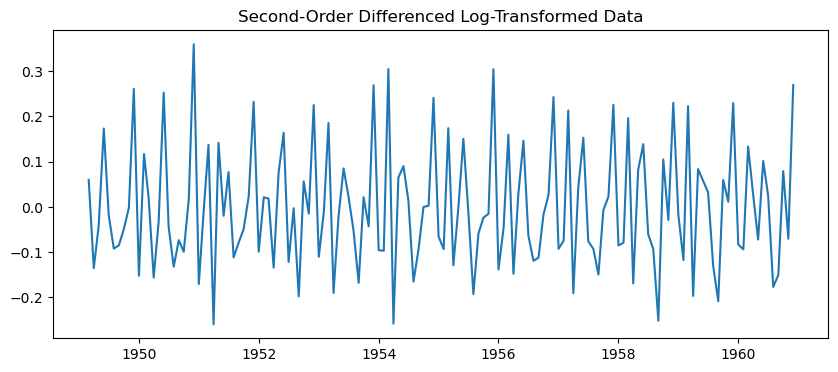

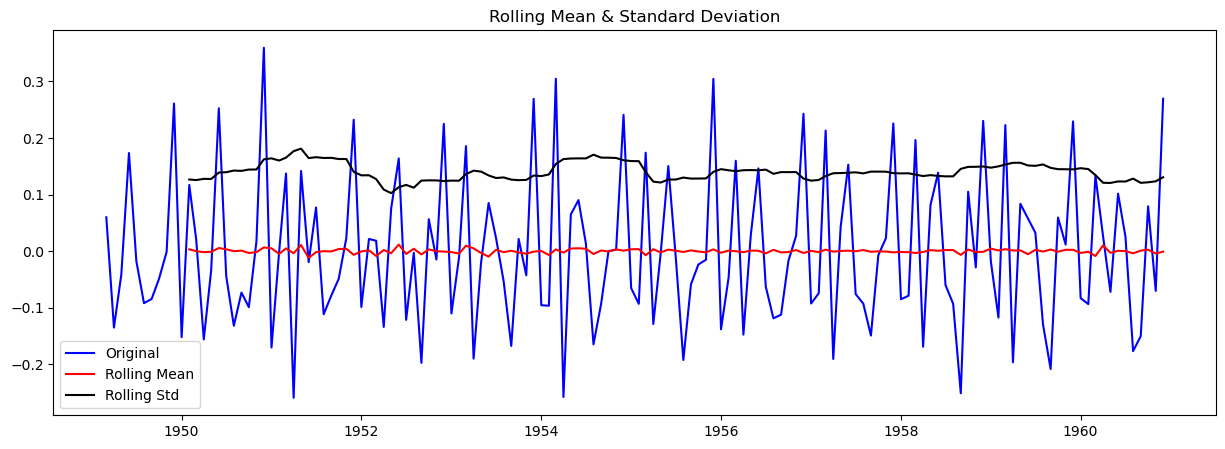

Results of Dickey-Fuller Test:
Test Statistic                 -8.20
p-value                         0.00
#Lags Used                     13.00
Number of Observations Used   128.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [45]:
# Apply second-order differencing (differencing twice)
data_log_diff2 = data_log.diff().diff().dropna()

# Plot the second-order differenced data
plt.figure(figsize=(10, 4))
plt.plot(data_log_diff2)
plt.title('Second-Order Differenced Log-Transformed Data')
plt.show()

# Test for stationarity on the second-order differenced log-transformed data
test_stationarity(data_log_diff2)

- From the outputs of the **Augmented Dickey Fuller Test**,
    - **Rolling Mean** is very close to 0.
    - **Rolling Standard Deviation** displays a slight uptrend over time.
    - **Test Statistic : (-2.83)** > **Critical Value (5%) : (-2.88)**. 
    - **p-value (0.05)** > **0.05**
- From the above values, we will use the above time series despite it just fails on the **stationarity** test.
- Effect of **double-differencing** would be too heavy on the data and might result in poor performance.

# <center>Modeling</center>

## <center>ARIMA</center> 
### <center>Auto Regressive Integrated Moving Average</center> 

- **ARIMA** model is a combination of 3 models :
    - **AR (p) : Auto Regressive**
    - **I (d) : Integrated**
    - **MA (q) : Moving Average**

- **(p,d,q)** is known as the order of the **ARIMA** model. Values of these parameters are based on the above mentioned models.  
    - **p** : Number of auto regressive terms. 
    - **d** : Number of differencing orders required to make the time series stationary.
    - **q** : Number of lagged forecast errors in the prediction equation.

- Selection criteria for the order of **ARIMA** model : 
    - **p** : Lag value where the **Partial Autocorrelation (PACF)** graph cuts off or drops to 0 for the 1st instance.
    - **d** : Number of times differencing is carried out to make the time series stationary.
    - **q** : Lag value where the **Autocorrelation (ACF)** graph crosses the upper confidence interval for the 1st instance.

#### **Check ACF and PACF Plots**

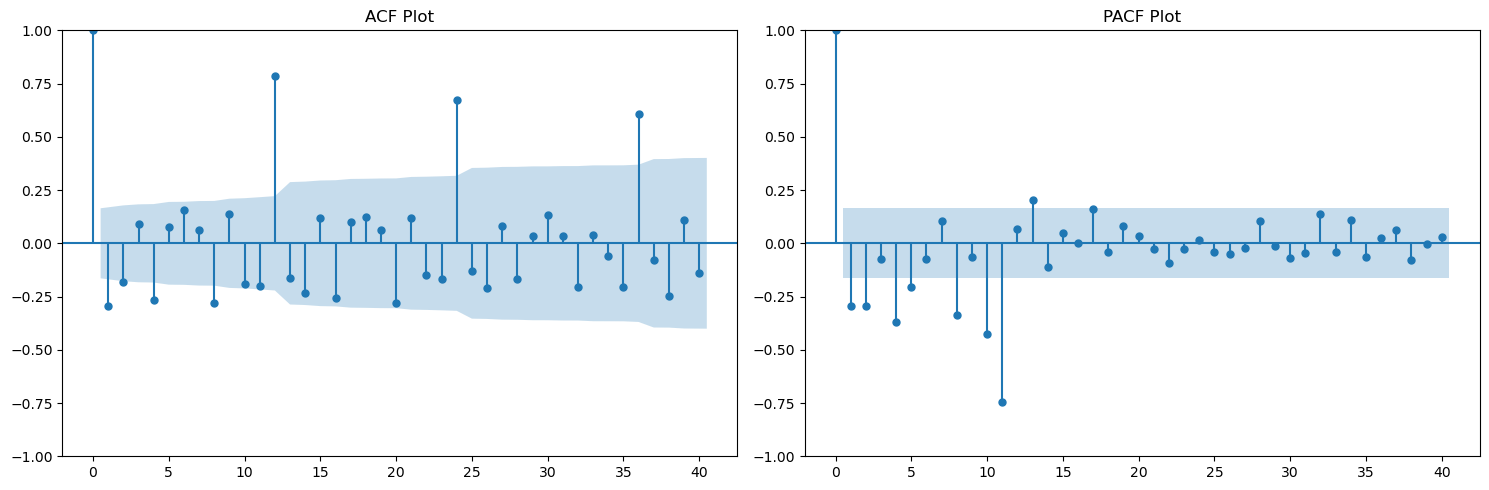

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# ACF plot (to determine 'q')
plot_acf(data_log_diff2, lags=40, ax=ax[0])  
ax[0].set_title('ACF Plot')

# PACF plot (to determine 'p')
plot_pacf(data_log_diff2, lags=40, ax=ax[1])  
ax[1].set_title('PACF Plot')

# Show the combined plot
plt.tight_layout()
plt.show()

- **ACF** graph provides the correlation between the time series & it's lags. For the above time series, we can observe a positive lowering correlation.
- **PACF** graph provides the correlation between the time series and individual lags. These correlation coefficients are unlike the mutual correlations that are calculated in the presence of other features.
- From the **PACF** graph above, the 1st lag is out of the confidence interval and probably the most significant lag. It probably dictates the pattern for the **ACF** graph where the next lag follows it's previous lag.

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  115
Model:                 ARIMA(1, 2, 2)   Log Likelihood                  98.738
Date:                Sat, 19 Oct 2024   AIC                           -189.476
Time:                        22:25:06   BIC                           -178.566
Sample:                    01-01-1949   HQIC                          -185.049
                         - 07-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5763      0.196     -2.936      0.003      -0.961      -0.192
ma.L1         -0.1602     94.522     -0.002      0.999    -185.421     185.100
ma.L2         -0.8398     79.303     -0.011      0.9

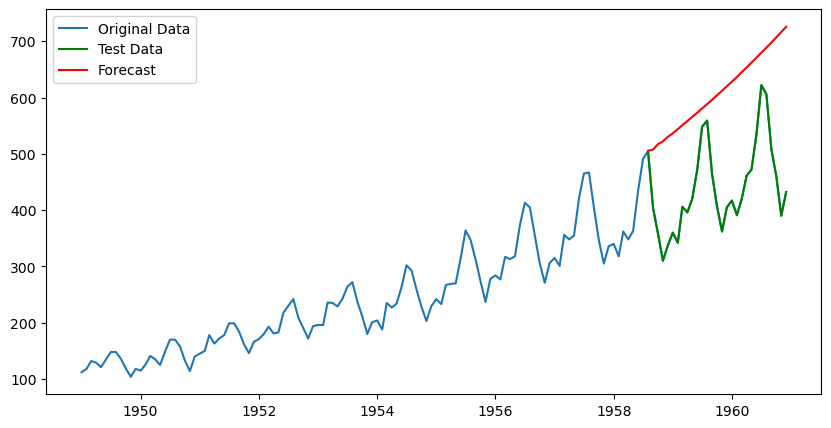

In [66]:
split_size = int(len(data_log) * 0.8)
train = data_log[:split_size]
test = data_log[split_size:]


model = ARIMA(train, order=(1, 2, 2))

# Fit the model on training data
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Forecast the length of the test set
forecast = model_fit.forecast(steps=len(test))

# Invert the log transformation to get back to the original scale
forecast_inverted = np.exp(forecast)

# Plot the forecasted values and the test set
plt.figure(figsize=(10, 5))
plt.plot(data['Passengers'], label='Original Data')
plt.plot(test.index, np.exp(test), label='Test Data', color='green')
plt.plot(test.index, forecast_inverted, label='Forecast', color='red')
plt.legend()
plt.show()

In [68]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Calculate RMSE
rmse = sqrt(mean_squared_error(test, forecast))  # 'test' is your actual values, 'forecast' are your predicted values
print('RMSE: %.3f' % rmse)

RMSE: 0.366


In [70]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE
mape = mean_absolute_percentage_error(test, forecast)
print('MAPE: %.3f' % mape)

MAPE: 5.517


#### **Summary of ARIMA Model Results:**
The ARIMA model achieved a RMSE of 0.366 and a MAPE of 5.5%, indicating reasonably accurate predictions with an average error of 5.5%. The model captures the underlying trend well but may miss capturing the seasonal variations present in the data, as seen in the periodic rise and fall of passenger numbers.

#### **Why Move to SARIMA:**
While ARIMA handles trends, it doesn't account for the clear seasonality observed in the time series (e.g., annual fluctuations in passenger numbers). SARIMA (Seasonal ARIMA) will incorporate both trend and seasonality, improving the model’s ability to forecast cyclical patterns, which is essential for more accurate long-term forecasting.

## <center>SARIMA</center>
### <center>Seasonal Auto Regressive Integrated Moving Average</center> 

- **SARIMA** model is an extension of the ARIMA model that can handle the seasonal effects of the data.
- It has kind of 2 orders **(p,d,q) x (P,D,Q,M)**. 
- **(p,d,q)** is the order that is similar to the order of the **ARIMA** model. 
- **(P,D,Q,M)** is known as the Seasonal Order where **(P,D,Q)** are similar to the **(p,d,q)** of the ARIMA model. 
- It's selection criteria is similar as well with an important condition i.e to handle the seasonality by differencing the data with the frequency of seasonal period or periodicity, **M** and check the **PACF** & **ACF** values at the **Mth** lag value. 

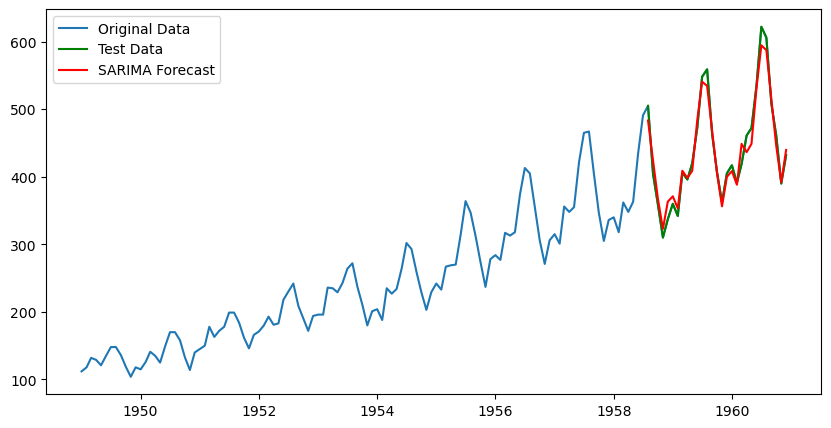

RMSE (SARIMA): 0.03405491709936676


In [73]:
# Example SARIMA Model:
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit()

# Forecasting
sarima_forecast = sarima_fit.forecast(steps=len(test))

# Invert log transformation
sarima_forecast_inverted = np.exp(sarima_forecast)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(data['Passengers'], label='Original Data')
plt.plot(test.index, np.exp(test), label='Test Data', color='green')
plt.plot(test.index, sarima_forecast_inverted, label='SARIMA Forecast', color='red')
plt.legend()
plt.show()

# Evaluate SARIMA model
rmse_sarima = sqrt(mean_squared_error(test, sarima_forecast))
print(f'RMSE (SARIMA): {rmse_sarima}')

In [75]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# For ARIMA or SARIMA forecasts
mape = mean_absolute_percentage_error(test, forecast)
print('MAPE: %.3f' % mape)

MAPE: 5.517


## **Diagnostics to Perform:**
#### (1) **Residual Analysis:**

- **Check for Stationarity:** The residuals should resemble white noise (i.e., have a mean of zero, constant variance, and no autocorrelation)

- **Plot Residuals:** A plot of residuals over time should show no discernible patterns (trends or seasonality).

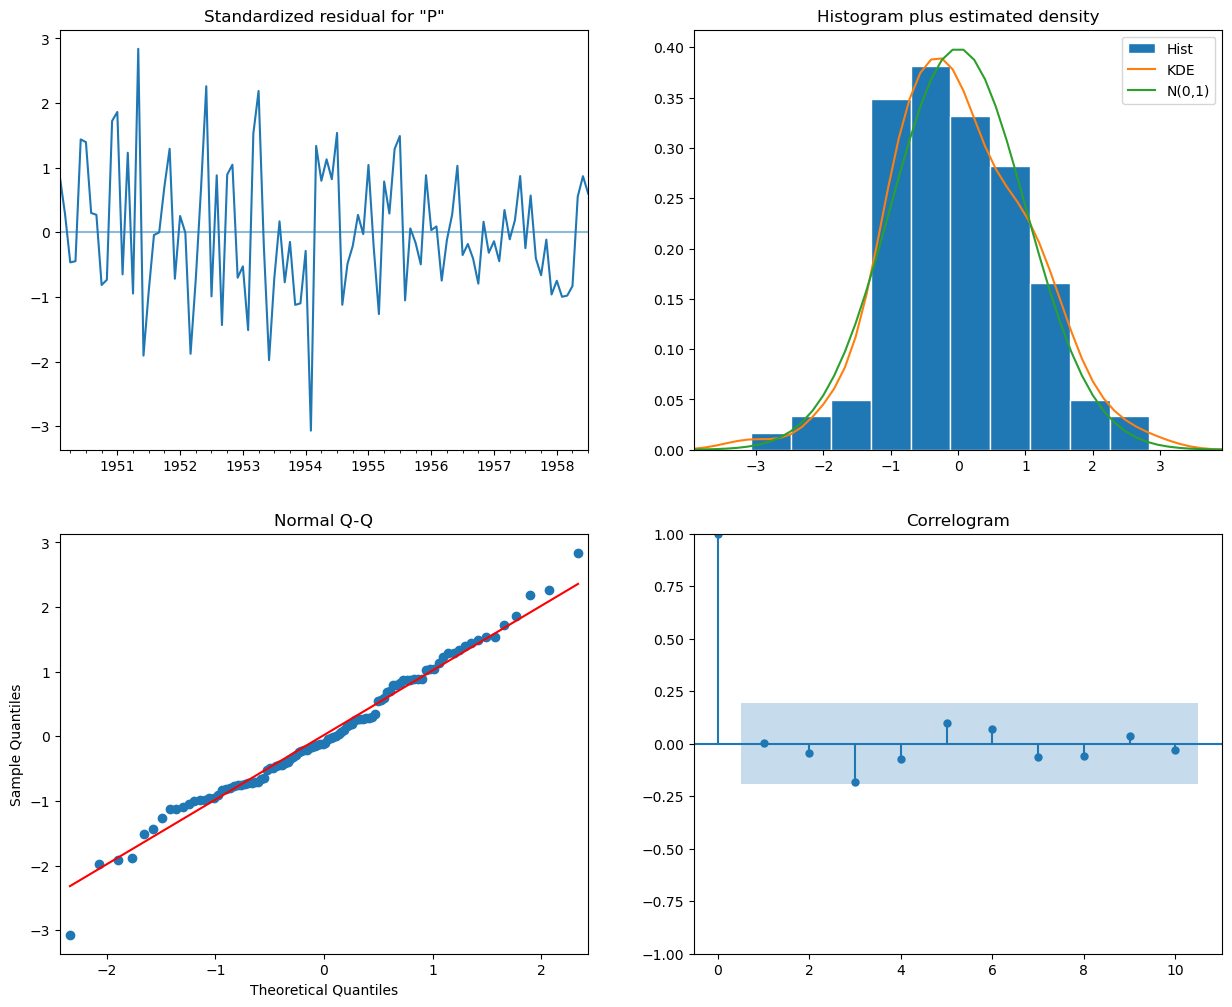

In [88]:
sarima_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

**Conclusion:**

The SARIMA model seems to perform well based on the diagnostic checks. The residuals are approximately normally distributed, show no clear patterns, and have no significant autocorrelation.

## **Final Result:**
The SARIMA model provides accurate forecasts for the given time series, with a low RMSE of 0.034 and a MAPE of 5.52%. This indicates that the model's predictions are, on average, within 5.5% of the actual values, showing that it captures both the trend and seasonal patterns effectively. Visual inspection also demonstrates that the model tracks the periodic fluctuations of passenger numbers with minor deviations at peaks. Overall, the SARIMA model proves to be well-suited for forecasting this dataset, with potential for further refinement if necessary for more precise seasonal variations.